In [1]:
import os
import sys
os.getcwd()

'/home/kapil'

In [22]:
sys.path.append(r'C:\Users\KapilYadav\Downloads\Python\quantum-trading-platform-using-linear-regression')
os.getcwd()

'C:\\Users\\KapilYadav'

In [23]:
import pandas as pd
import yfinance as yf
from datetime import date
from indicators import add_technical_indicators, volatility
from returns import get_returns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from utility_helper import get_previous_date, drop_highly_correlated_features
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import xgboost as xgb
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = yf.download("^NSEI", start="1970-01-01", end=date.today())


[*********************100%***********************]  1 of 1 completed


In [25]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)


In [26]:
df= add_technical_indicators(df, ohlc="Close", time_frame=10)
df = get_returns(df, 'Close', 1)
df = get_returns(df, 'Close', 5)
df = get_returns(df, 'Close', 10)

In [27]:
df = volatility(df)


In [28]:
df['next_close'] = df['Close'].shift(-1)

In [29]:
clone_df = df.copy()
df.dropna(inplace=True)

In [ ]:
df = drop_highly_correlated_features(df, 0.88)
print(df.columns)
print(df.head(50))
print(df.tail(50))

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'sma_close_10',
       'rsi_close_10', 'mom_close_10', 'bbands_close_10_m_pct',
       'bbands_close_10_u_pct', 'bbands_close_10_l_pct',
       'bbands_close_10_width_pct', 'macd_close_pct', 'macd_signal_close_pct',
       'macd_hist_close_pct', 'ret_1', 'ret_5', 'ret_10', 'volatility_5d_pct',
       'volatility_10d_pct', 'volatility_20d_pct', 'next_close'],
      dtype='object', name='Price')
Price             Close         High          Low         Open  Volume  \
Date                                                                     
2007-10-16  5668.049805  5708.350098  5578.450195  5670.649902       0   
2007-10-17  5559.299805  5658.899902  5107.299805  5658.899902       0   
2007-10-18  5351.000000  5736.799805  5269.649902  5551.100098       0   
2007-10-19  5215.299805  5390.850098  5101.750000  5360.350098       0   
2007-10-22  5184.000000  5247.399902  5070.899902  5202.750000       0   
2007-10-23  5473.700195  5488.500000

In [ ]:
df.drop('bbands_close_10_m_pct', axis=1, inplace=True) # dropped it from df since, it was having zeros in all columns


In [32]:
corr = df.corr()


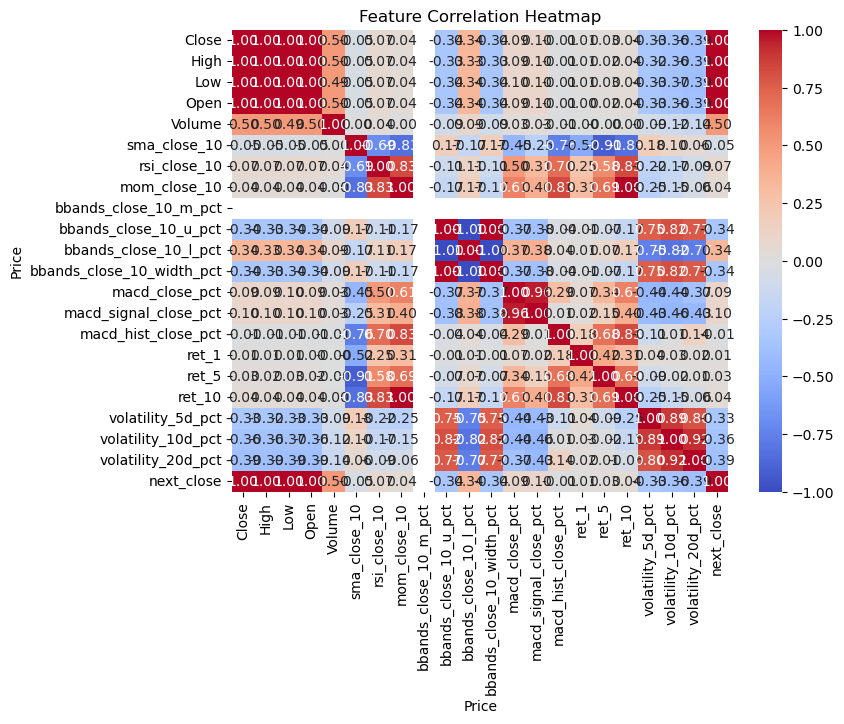

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [34]:
features = [
    'Close', 'High', 'Low', 'Open', 'Volume', 'sma_close_10',
       'rsi_close_10', 'mom_close_10', 'bbands_close_10_m_pct',
       'bbands_close_10_u_pct', 'bbands_close_10_l_pct',
       'bbands_close_10_width_pct', 'macd_close_pct', 'macd_signal_close_pct',
       'macd_hist_close_pct', 'ret_1', 'ret_5', 'ret_10', 'volatility_5d_pct',
       'volatility_10d_pct', 'volatility_20d_pct'
    ]

In [35]:
X = df[features]
y = df['next_close']


In [ ]:
split_date = get_previous_date(10)

In [37]:
X_train = X[X.index < split_date]
X_test  = X[X.index >= split_date]

y_train = y[y.index < split_date]
y_test  = y[y.index >= split_date]

In [38]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,   # smaller learning rate
    max_depth=3,           # shallow trees
    subsample=0.8,         # optional: adds regularization
    colsample_bytree=0.8,
    random_state=42
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", model)
], memory=None)

In [39]:
X_train, y_train

(Price             Close         High          Low         Open  Volume  \
 Date                                                                     
 2007-10-16  5668.049805  5708.350098  5578.450195  5670.649902       0   
 2007-10-17  5559.299805  5658.899902  5107.299805  5658.899902       0   
 2007-10-18  5351.000000  5736.799805  5269.649902  5551.100098       0   
 2007-10-19  5215.299805  5390.850098  5101.750000  5360.350098       0   
 2007-10-22  5184.000000  5247.399902  5070.899902  5202.750000       0   
 ...                 ...          ...          ...          ...     ...   
 2011-02-18  5458.950195  5599.250000  5441.950195  5557.549805       0   
 2011-02-21  5518.600098  5526.250000  5413.100098  5456.600098       0   
 2011-02-22  5469.200195  5519.450195  5437.299805  5504.399902       0   
 2011-02-23  5437.350098  5495.200195  5427.549805  5452.450195       0   
 2011-02-24  5262.700195  5423.399902  5242.500000  5408.750000       0   
 
 Price       sma_close_

In [40]:
print('🚀 Model Training begins... 🔂 ')
pipeline.fit(X_train, y_train)
print('🚀 Model is trained 🙂  ')

🚀 Model Training begins... 🔂 
🚀 Model is trained 🙂  


In [ ]:
joblib.dump(pipeline, "NiFTY_next_open_prediction_experiment.pkl")

['NiFTY_next_open_prediction.pkl']

In [42]:
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R2 Score:", r2)

direction_accuracy = np.mean(np.sign(y_pred - X_test['Close']) == np.sign(y_test - X_test['Close']))
print("Direction Accuracy:", direction_accuracy)

MSE: 78970685.26002063
R2 Score: -0.9843193940453514
Direction Accuracy: 0.4704922491161273


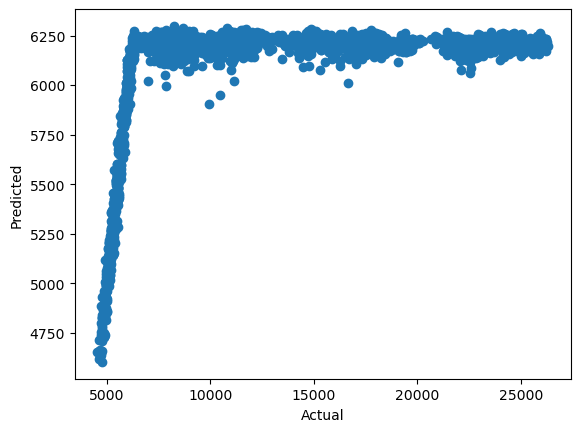

In [43]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()